# “Hello, world!”

Import Sionna:

In [14]:
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# IPython "magic function" for inline plots
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf

Let us first create a [BinarySource](https://nvlabs.github.io/sionna/api/utils.html?highlight=binarysource#binarysource) to generate a random batch of bit vectors that we can map to constellation symbols:

In [2]:
batch_size = 1000 # Number of symbols we want to generate
num_bits_per_symbol = 2 # 16-QAM has four bits per symbol
binary_source = sionna.utils.BinarySource()
b = binary_source([batch_size, num_bits_per_symbol])
b

<tf.Tensor: shape=(1000, 2), dtype=float32, numpy=
array([[0., 0.],
       [1., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 0.],
       [1., 0.]], dtype=float32)>

Next, let us create a [Constellation](https://nvlabs.github.io/sionna/api/mapping.html#sionna.mapping.Constellation) and visualize it:

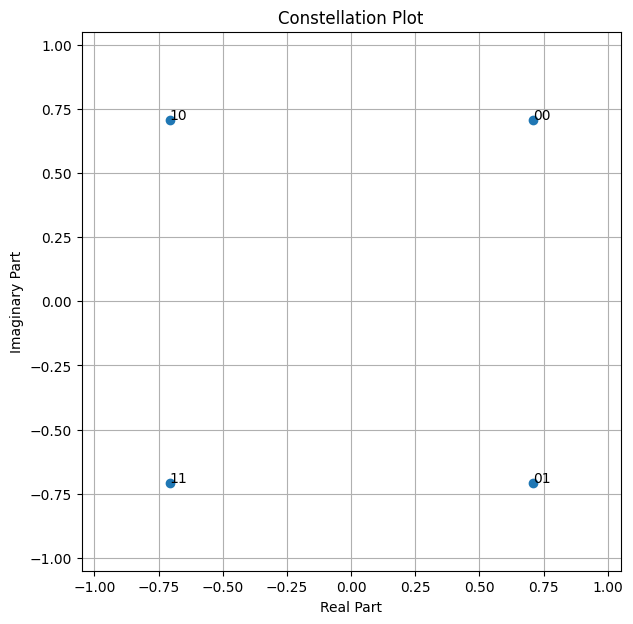

In [3]:
constellation = sionna.mapping.Constellation("qam", num_bits_per_symbol)
constellation.show();

We now need a [Mapper](https://nvlabs.github.io/sionna/api/mapping.html#mapper) that maps each row of b to the constellation symbols according to the bit labeling shown above.

In [4]:
mapper = sionna.mapping.Mapper(constellation=constellation)
x = mapper(b)
x[:10]

<tf.Tensor: shape=(10, 1), dtype=complex64, numpy=
array([[ 0.70710677+0.70710677j],
       [-0.70710677-0.70710677j],
       [ 0.70710677-0.70710677j],
       [-0.70710677-0.70710677j],
       [-0.70710677+0.70710677j],
       [ 0.70710677+0.70710677j],
       [-0.70710677+0.70710677j],
       [-0.70710677-0.70710677j],
       [-0.70710677+0.70710677j],
       [-0.70710677-0.70710677j]], dtype=complex64)>

Let us now make things a bit more interesting a send our symbols over and [AWGN channel](https://nvlabs.github.io/sionna/api/channel.html#sionna.channel.AWGN):

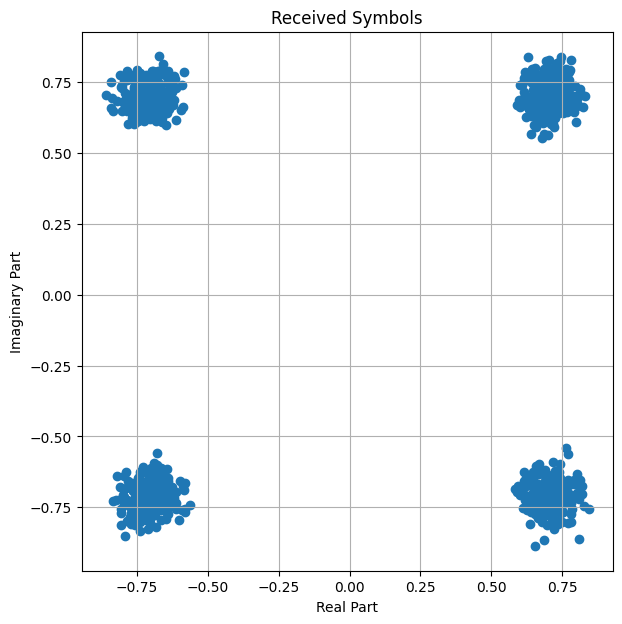

In [5]:
awgn = sionna.channel.AWGN()
ebno_db = 20 # Desired Eb/No in dB
no = sionna.utils.ebnodb2no(ebno_db, num_bits_per_symbol, coderate=1)
y = awgn([x, no])

# Visualize the received signal
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
plt.scatter(np.real(y), np.imag(y));
ax.set_aspect("equal", adjustable="box")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True, which="both", axis="both")
plt.title("Received Symbols");

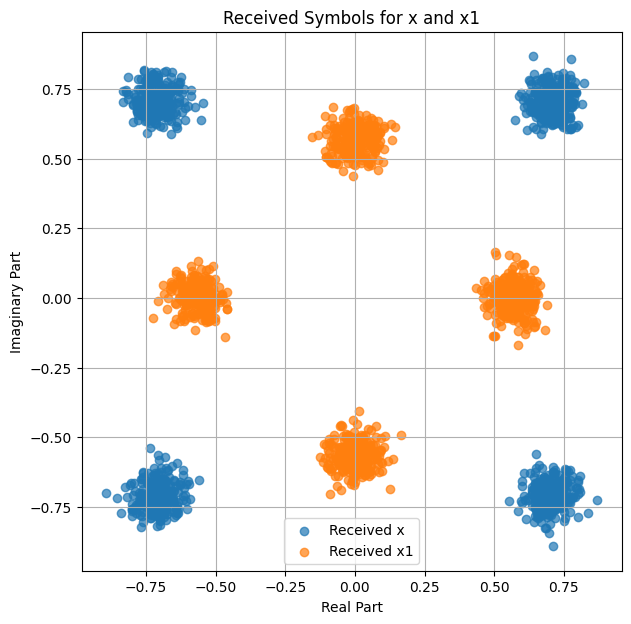

In [8]:

# Generate noisy observations
awgn = sionna.channel.AWGN()
ebno_db = 20  # Desired Eb/No in dB
no = sionna.utils.ebnodb2no(ebno_db, num_bits_per_symbol, coderate=1)
x1 = (0.4 - 0.4j) * x

# Add AWGN noise
y = awgn([x, no])
y1 = awgn([x1, no])

# Plotting the original signal x and scaled signal x1
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)

# Plot the received symbols for x
plt.scatter(np.real(y), np.imag(y), label='Received x', alpha=0.7)

# Plot the received symbols for x1
plt.scatter(np.real(y1), np.imag(y1), label='Received x1', alpha=0.7)

# Formatting the plot
ax.set_aspect("equal", adjustable="box")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True, which="both", axis="both")
plt.title("Received Symbols for x and x1")
plt.legend()
plt.show()

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Conv2D, LayerNormalization
from tensorflow.nn import relu

from sionna.channel.tr38901 import Antenna, AntennaArray, CDL
from sionna.channel import OFDMChannel
from sionna.mimo import StreamManagement
from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer, RemoveNulledSubcarriers, ResourceGridDemapper
from sionna.utils import BinarySource, ebnodb2no, insert_dims, flatten_last_dims, log10, expand_to_rank
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.mapping import Mapper, Demapper
from sionna.utils.metrics import compute_ber
from sionna.utils import sim_ber

############################################
## Channel configuration
carrier_frequency = 3.5e9 # Hz
delay_spread = 100e-9 # s
cdl_model = "C" # CDL model to use
speed = 10.0 # Speed for evaluation and training [m/s]
# SNR range for evaluation and training [dB]
ebno_db_min = -5.0
ebno_db_max = 10.0

############################################
## OFDM waveform configuration
subcarrier_spacing = 30e3 # Hz
fft_size = 128 # Number of subcarriers forming the resource grid, including the null-subcarrier and the guard bands
num_ofdm_symbols = 14 # Number of OFDM symbols forming the resource grid
dc_null = True # Null the DC subcarrier
num_guard_carriers = [5, 6] # Number of guard carriers on each side
pilot_pattern = "kronecker" # Pilot pattern
pilot_ofdm_symbol_indices = [2, 11] # Index of OFDM symbols carrying pilots
cyclic_prefix_length = 0 # Simulation in frequency domain. This is useless

############################################
## Modulation and coding configuration
num_bits_per_symbol = 2 # QPSK
coderate = 0.5 # Coderate for LDPC code

############################################
## Neural receiver configuration
num_conv_channels = 128 # Number of convolutional channels for the convolutional layers forming the neural receiver

############################################
## Training configuration
num_training_iterations = 30000 # Number of training iterations
training_batch_size = 128 # Training batch size
model_weights_path = "neural_receiver_weights" # Location to save the neural receiver weights once training is done

############################################
## Evaluation configuration
results_filename = "neural_receiver_results" # Location to save the results


stream_manager = StreamManagement(np.array([[1]]), # Receiver-transmitter association matrix
                                  1)               # One stream per transmitter
resource_grid = ResourceGrid(num_ofdm_symbols = num_ofdm_symbols,
                             fft_size = fft_size,
                             subcarrier_spacing = subcarrier_spacing,
                             num_tx = 1,
                             num_streams_per_tx = 1,
                             cyclic_prefix_length = cyclic_prefix_length,
                             dc_null = dc_null,
                             pilot_pattern = pilot_pattern,
                             pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices,
                             num_guard_carriers = num_guard_carriers)
# Codeword length. It is calculated from the total number of databits carried by the resource grid, and the number of bits transmitted per resource element
n = int(resource_grid.num_data_symbols*num_bits_per_symbol)
# Number of information bits per codeword
k = int(n*coderate)

ut_antenna = Antenna(polarization="single",
                     polarization_type="V",
                     antenna_pattern="38.901",
                     carrier_frequency=carrier_frequency)

bs_array = AntennaArray(num_rows=1,
                        num_cols=1,
                        polarization="dual",
                        polarization_type="VH",
                        antenna_pattern="38.901",
                        carrier_frequency=carrier_frequency)

## Transmitter
binary_source = BinarySource()
mapper = Mapper("qam", num_bits_per_symbol)
rg_mapper = ResourceGridMapper(resource_grid)

## Channel
cdl = CDL(cdl_model, delay_spread, carrier_frequency,
          ut_antenna, bs_array, "uplink", min_speed=speed)
channel = OFDMChannel(cdl, resource_grid, normalize_channel=True, return_channel=True)

rg_demapper = ResourceGridDemapper(resource_grid, stream_manager) # Used to extract data-carrying resource elements

batch_size = 64
ebno_db = tf.fill([batch_size], 5.0)
no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)

## Transmitter
# Generate codewords
c = binary_source([batch_size, 1, 1, n])
print("c shape: ", c.shape)
# Map bits to QAM symbols
x = mapper(c)
print("x shape: ", x.shape)
# Map the QAM symbols to a resource grid
x_rg = rg_mapper(x)
print("x_rg shape: ", x_rg.shape)

######################################
## Channel
# A batch of new channel realizations is sampled and applied at every inference
no_ = expand_to_rank(no, tf.rank(x_rg))
y,_ = channel([x_rg, no_])
print("y shape: ", y.shape)

c shape:  (64, 1, 1, 2784)
x shape:  (64, 1, 1, 1392)
x_rg shape:  (64, 1, 1, 14, 128)
y shape:  (64, 1, 2, 14, 128)


In [23]:
# x_rg[:, 0, 0, :, 30]

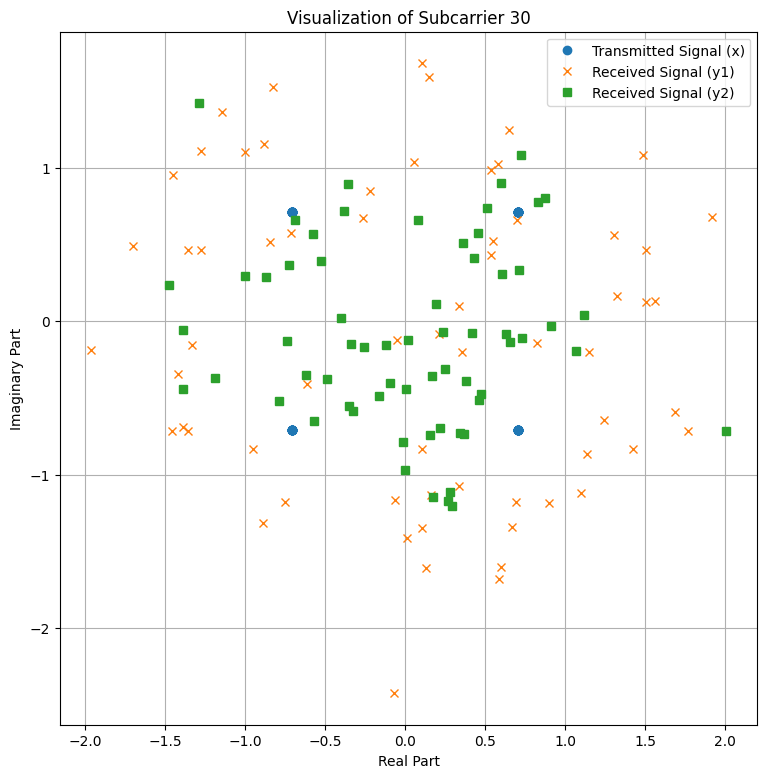

In [27]:
# prompt: 帮我将x和y中对应的子载波数据（比如第30个子载波），抽出来并按照前面的代码可视化出来一一对应，请注意数据的维度为[batch_size, 发射端数据流，接收端数据流，时隙符号数，子载波数]，其中y对应有两个接收通道，那么我要设置相应的y1和y2

import matplotlib.pyplot as plt
import numpy as np

# Assuming 'x' and 'y' are defined as in your previous code, with shape [batch_size, Tx streams, Rx streams, time slots, subcarriers]
# and y has two receive channels (y1 and y2).

def visualize_subcarrier(x, y, symb, subcarrier_index):
  """Visualizes the specified subcarrier for x and y1, y2.

  Args:
    x: Transmitted signal.
    y: Received signal.
    subcarrier_index: Index of the subcarrier to visualize.
  """

  # Extract the specified subcarrier from x and y
  x_subcarrier = x_rg[:, 0, 0, symb, subcarrier_index]  # Assuming single Tx and Rx stream for simplicity
  y1_subcarrier = y[:, 0, 0, symb, subcarrier_index] # Extract data from the first receiver
  y2_subcarrier = y[:, 0, 1, symb, subcarrier_index] # Extract data from the second receiver

  # Create the plot
  plt.figure(figsize=(9, 9))
  plt.plot(np.real(x_subcarrier), np.imag(x_subcarrier), 'o', label='Transmitted Signal (x)')
  plt.plot(np.real(y1_subcarrier), np.imag(y1_subcarrier), 'x', label='Received Signal (y1)')
  plt.plot(np.real(y2_subcarrier), np.imag(y2_subcarrier), 's', label='Received Signal (y2)')
  plt.xlabel('Real Part')
  plt.ylabel('Imaginary Part')
  plt.title(f'Visualization of Subcarrier {subcarrier_index}')
  plt.legend()
  plt.grid(True)
  plt.show()


# Example usage: Visualize subcarrier 30
visualize_subcarrier(x, y, 0, 30)

In [24]:
print(x_rg[:, 0, 0, 0, subcarrier_index].shape)

(64,)
